<a href="https://colab.research.google.com/github/ravindrabajpai/sp_forecasting/blob/main/sbi_price_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ravindrabajpai/sp_forecasting/main/SBIN.NS-2.csv'
df = pd.read_csv(url)



In [53]:
df.size
df.columns

Index(['index', 'Date', 'Adj Close', 'Volume', 'Sentiments'], dtype='object')

In [55]:
import numpy as np
temperature = np.zeros(df.size,)
raw_data = np.zeros((df.size, len(df.columns) - 1))
temperature = df[['Adj Close']].to_numpy()
raw_data = df[['Adj Close', 'Volume', 'Sentiments']].to_numpy()

print(temperature[0])
print(raw_data[0])

[280.892944]
[2.80892944e+02 1.00778530e+07 0.00000000e+00]


In [56]:
print(len(temperature))
print(len(raw_data))

1236
1236


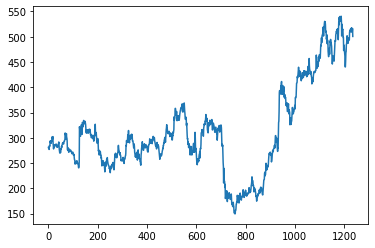

In [57]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

In [59]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 618
num_val_samples: 309
num_test_samples: 309


In [60]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [61]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [71]:
sampling_rate = 6
sequence_length = 20
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 4

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [72]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (4, 20, 3)
targets shape: (4, 1)


In [85]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("sbins.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("sbins.keras")


Epoch 1/20
125/125 [==============================] - 4s 18ms/step - loss: 82986.8672 - mae: 284.7892 - val_loss: 129738.2656 - val_mae: 353.8694
Epoch 2/20
125/125 [==============================] - 2s 15ms/step - loss: 81741.3438 - mae: 282.5906 - val_loss: 129176.6406 - val_mae: 353.0768
Epoch 3/20
125/125 [==============================] - 2s 16ms/step - loss: 80508.8203 - mae: 280.3963 - val_loss: 128403.9297 - val_mae: 351.9222
Epoch 4/20
125/125 [==============================] - 2s 15ms/step - loss: 79575.2500 - mae: 278.7162 - val_loss: 126781.9766 - val_mae: 349.6190
Epoch 5/20
125/125 [==============================] - 2s 16ms/step - loss: 78766.5078 - mae: 277.2627 - val_loss: 124955.1406 - val_mae: 347.0579
Epoch 6/20
125/125 [==============================] - 2s 15ms/step - loss: 78036.0156 - mae: 275.9109 - val_loss: 123912.5469 - val_mae: 345.5535
Epoch 7/20
125/125 [==============================] - 2s 16ms/step - loss: 77584.7812 - mae: 275.1182 - val_loss: 123130.609

In [89]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
 

48/48 [==============================] - 0s 4ms/step - loss: 114216.9062 - mae: 331.2206
Test MAE: 331.22
